# Getting started with TinyTimeMixer (TTM) Rolling Predictions

This notebooke demonstrates the usage of a pre-trained or finetuned `TinyTimeMixer` model for rolling predictions. 

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We then do rolling predictions of this model to keep predicting for longer forecast lengths.

Pre-trained TTM models will be fetched from the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1). We also fine-tune a model and use the finetuned model for the same rolling predictions.

In [1]:
import os
import tempfile

from transformers import Trainer, TrainingArguments, set_seed

from tsfm_public import TinyTimeMixerForPrediction, load_dataset
from tsfm_public.toolkit import RecursivePredictor, RecursivePredictorConfig
from tsfm_public.toolkit.visualization import plot_predictions

/dccstor/tsfm-irl/conda_envs/envs/tsfmhf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-30 04:01:01.675786: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Important arguments

In [23]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "etth1"

dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"

# DATA_ROOT_PATH = "/dccstor/tsfm23/datasets/"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

ROLLING_PREDICTION_LENGTH = 192
TTM_MODEL_URL = (
    "ibm-granite/granite-timeseries-ttm-v1"  # POINT TO A ZEROSHOT MODEL OR A FINETUNED MODEL TO DO ROLLING INFERENCE.
)

## LOAD BASE MODEL

In [24]:
base_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_URL, revision=TTM_MODEL_REVISION)

base_model_context_length = base_model.config.context_length
base_model_forecast_length = base_model.config.prediction_length

print(base_model_context_length, base_model_forecast_length)

/dccstor/tsfm-irl/conda_envs/envs/tsfmhf/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


512 96


## LOAD DATA

In [25]:
_, _, dset_test = load_dataset(
    dataset_name=target_dataset,
    context_length=base_model_context_length,
    forecast_length=ROLLING_PREDICTION_LENGTH,
    fewshot_fraction=1.0,
    dataset_path=dataset_path,
)

INFO:p-49045:t-22385749930752:data_handling.py:load_dataset:Dataset name: etth1, context length: 512, prediction length 192
INFO:p-49045:t-22385749930752:data_handling.py:load_dataset:Data lengths: train = 7937, val = 2689, test = 2689


## ROLLING PREDICTIONS

In [26]:
rec_config = RecursivePredictorConfig(
    model=base_model,
    requested_forecast_length=ROLLING_PREDICTION_LENGTH,
    model_forecast_length=base_model_forecast_length,
    loss=base_model.config.loss,
)
rolling_model = RecursivePredictor(rec_config)

In [27]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=rolling_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=32,
        seed=SEED,
    ),
)
# evaluate = zero-shot performance
print("+" * 20, "Test MSE zero-shot", "+" * 20)
zeroshot_output = zeroshot_trainer.evaluate(dset_test)
print(zeroshot_output)

INFO:p-49045:t-22385749930752:base.py:add_job:Adding job tentatively -- it will be properly scheduled when the scheduler starts


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.3921540379524231, 'eval_runtime': 1.5521, 'eval_samples_per_second': 1732.534, 'eval_steps_per_second': 54.766}


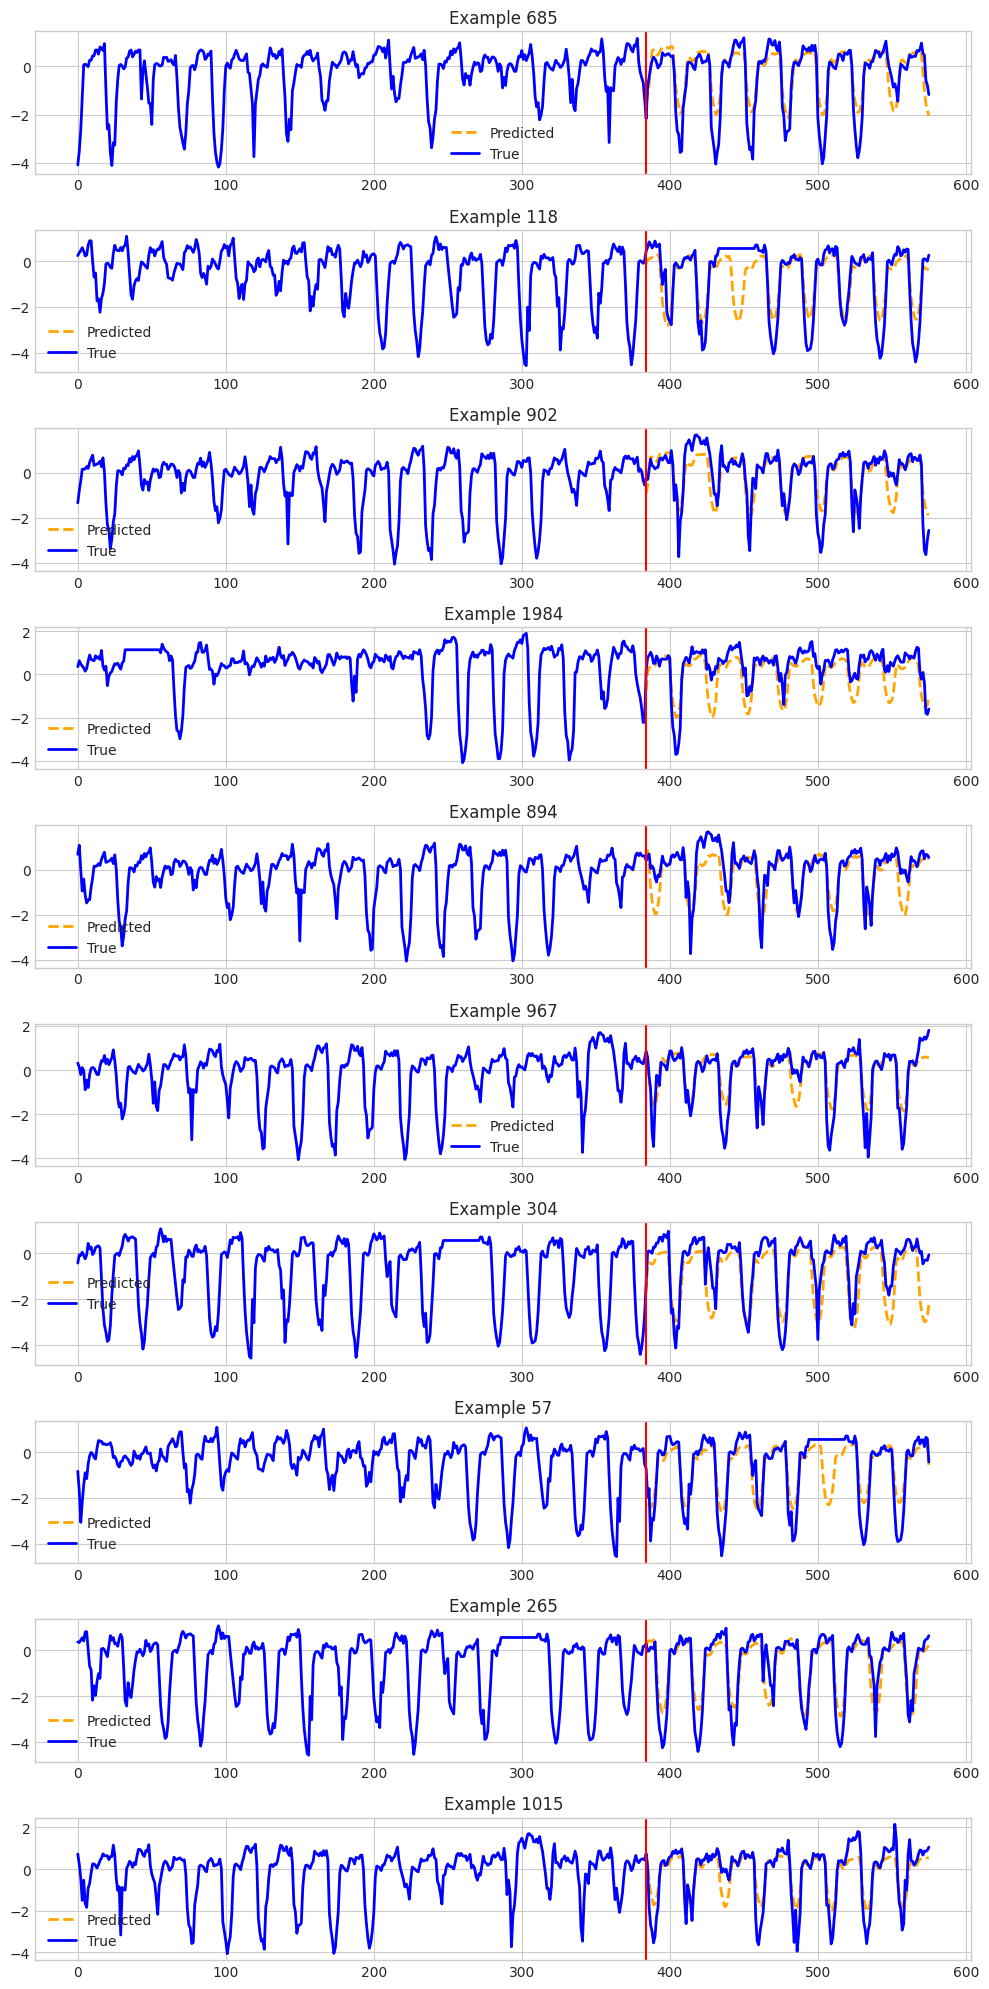

In [28]:
plot_predictions(
    model=zeroshot_trainer.model,
    dset=dset_test,
    plot_dir=os.path.join(OUT_DIR, target_dataset),
    plot_prefix="test_rolling",
    indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
    channel=0,
)